In [10]:
import numpy as np
from scipy.stats import poisson
from scipy.special import loggamma
import matplotlib.pyplot as plt 
from typing import Union
import polars as pl

PATH_DATA = 'data'

In [11]:
files_ = ['traces_attn_31dB.csv']
data = []
for i in files_:
    data_ =  pl.read_csv(rf'{PATH_DATA}/{i}', has_header=False, separator=",").to_numpy()
    mean_it = data_[:,:10].mean()
    data.append((data_[:,::3] - mean_it))

data = np.concatenate(data, axis=0)
data_train = data[::2]
data_test = data[1::2]
mean_ = data_train.mean()
std_ = data_train.std()
data_train  = (data_train - mean_) / std_
data_test  = (data_test - mean_) / std_

In [12]:
data_train.shape

(50000, 200)

In [13]:

def initialSetup():
    pass

def readAndFilter():
    pass



## Deleted Functions and Variables

### Variables

- `iNPhoton` : Dataset creation is not included in the processing 
- `iDataSet` : Dataset creation is not included in the processing 
- `nTimes` : Dataset creation is not included in the processing 
- `mSample` : Visual 
- `nDatUse` : Dataset creation is not included in the processing 
- `backgroundReject` : Dataset creation is not included in the processing 
- `peakValCut` : Dataset creation is not included in the processing 
- `peakPosCut` : Dataset creation is not included in the processing 
- `peakNumCut` : Dataset creation is not included in the processing 
- `coolConst` :
- `tAnneal` :
- `probDistName` : Visual
- `binFract` : Visual
- `outputImageSize` : Visual
- `partialFilePath` : Dataset creation is not included in the processing 
- `fileExt` : Dataset creation is not included in the processing 
- `nSamplePerTrace` : Dataset creation is not included in the processing 
- `nTracePerFile` : Dataset creation is not included in the processing 
- `useInputFile` : Dataset creation is not included in the processing 
- `pikaInput` : Dataset creation is not included in the processing 

### Functions

- `initialSetup` : Visual
- `readAndFilterData` : Dataset creation is not included in the processing 
- `optionallyRejectBackgroundTraces` : Dataset creation is not included in the processing
- `graphGlobalMeanTrace` : Visual 
- `graphSampleMiddleClusters` : Visual
- `graphClusterMeans` : Visual
- `graphSampleMiddleClusters` : Visual
- `graphClusterMean` : Visual
- `graphClusterDeviationsFromMean : `Visual`


In [ ]:



class PIKA:

    def __init__(self,
                nCool : int = 10,
                nGreedy : int = 10,
                tAnneal : float = 1,
                coolConst : float = 0.1,
                nSigma : float = 4.,
                random_seed : int = 137,
                verbose : bool = False
                 ):
        """

        Parameters
        ----------
        nCool : int 
            Number of optimizing rounds to perform
        nGreedy : int
            Number of rounds that should be run with the greedy algorithm
        nSigma : float
            Number of standard deviations from the mean of the probability distribution to generate
        verbose : bool
            Print information about processing steps.

        returns
        -------
        None
        """
        
        self.m = None 
        self.nObs = None
        self.s = None

        # Visual
        self.mSample = 1000
        self.binFract = 500
        self.dpi = 100
        self.outputImageSize = (6,3)
        self.styleName = 'seaborn-v0_8'
        self.verbose = verbose

        # Optimization
        self.nCool = nCool
        self.nGreedy = nGreedy

        # Model
        self.nSigma = nSigma
        self.tAnneal = tAnneal
        self.coolConst = coolConst
        # self.nPhotonAvgList = nPhotonAvgList

        # Random Process
        self.rng = np.random.default_rng(seed = random_seed)

        # Information
        self.kMove = None
        self.birthOfObsClust = None
        self.birthOfClust = None
        self.sqDevOfObsClust = None
        self.objFtn = []


    def findDotProductEffectivePhotonNumbers(self,
                                        data : np.array, 
                                        nPhotonAvg : float,
                                        meanTrace : np.array
        ):
        """
        Compute n_eff for every trace.

        Parameters
        ----------
        data : np.array
            Waveforms for a given coherent source.
        nPhotonAvg : float
            Mean photon number for the coherent source.
        meanTrace : np.array
            Array containing the average waveform of data.

        returns
        -------
        nPhotonEff : np.array
            Array of effective photon number.
        """
        nPhotonEff = nPhotonAvg * np.dot(data, meanTrace) / np.linalg.norm(meanTrace)

        if self.verbose:
            with plt.style.context(self.styleName):
                plt.figure(figsize = self.outputImageSize, dpi=self.dpi)
                plt.hist(nPhotonEff, alpha=0.8, bins=self.binFract)
                plt.ylabel('Voltage (a.u.)')
                plt.xlabel('Time (a.u.)')
                plt.tight_layout()
                plt.show()

        return nPhotonEff
    
    def groupProb(self,
                  data : np.array,
                  nPhoton : np.array,
                  probCum : np.array,
                  nPhotonEff : np.array,
                  ):
        """

        Parameters
        ----------
        data : np.array
            Waveforms for a given coherent source.
        nPhoton : np.array

        probCum : np.array
            Cumulative probability function.
        nPhotonAvg : float
            Mean photon number for the coherent source.
            
        Returns
        -------
        nPhotonOfClust : np.array
            Array containing the photon numbers associated to every cluster.
        iObsOfClust : list
            List containing an index array for each cluster.
        clustMeanTrace : np.array
            Array containing the average waveform for a given cluster.
        """
        # Shape (n,)
        nPhotonEffSortIndex = np.argsort(nPhotonEff)
        # Shape (n_cluster, inconsistent)
        iObsOfClust = np.array_split(
            ary = nPhotonEffSortIndex, 
            indices_or_sections = np.unique(np.round(self.nObs * probCum).astype(int))[:-1]
        )
        # Shape (n_cluster, s)
        clustMeanTrace = np.array([np.mean(data[iClust], axis=0) for iClust in iObsOfClust])
        # Shape (n_cluster,)
        nPhotonUse = nPhoton[:len(iObsOfClust)] #TODO make this more robust 
            
        return nPhotonUse, iObsOfClust, clustMeanTrace

    
    def createInitialClusters(self, 
            data : np.array,
            nPhotonEff : np.array,
            nPhotonAvg : float
        ):
        """

        Create initial clusters based on dot product.

        Parameters
        ----------
        data : np.array
            Waveforms for a given coherent source.
        nPhotonEff : np.array
            Array containing the number of elements in every cluster.
        nPhotonAvg : float
            Mean photon number for the coherent source.

        Returns
        -------
        nPhotonOfClust : np.array
            Array containing the photon numbers associated to every cluster.
        iObsOfClust : list
            List containing an index array for each cluster.
        clustMeanTrace : np.array
            Array containing the average waveform for a given cluster.

        """
        # Poisson function in article
        ##  Probability distribution based on Confidence interval
        sigma = np.sqrt(nPhotonAvg)
        nPhoton = np.arange(
            start = max(int(np.floor(nPhotonAvg - sigma * self.nSigma)), 0), 
            stop = int(np.ceil(nPhotonAvg + sigma * self.nSigma)) + 1,
            step = 1
        )

        probCum = poisson.cdf(nPhoton, nPhotonAvg)
        
        nPhotonOfClust, iObsOfClust, clustMeanTrace = self.groupProb(
            data = data,
            nPhoton = nPhoton,
            probCum = probCum,
            nPhotonEff = nPhotonEff
        )

        return nPhotonOfClust, iObsOfClust, clustMeanTrace


    
    def probComboLogLikelihood(self,
            nList : np.array,
            freqList : np.array,
            mu : float
        ):
        """

        Poisson/Combinatorial log-likelihood term of the objective function.
        
        Parameters
        ----------
        nList : np.array
            Array containing the photon number associated with every cluster.
        freqList : np.array
            Array containing the number of elements in every cluster.
        mu : float
            Mean photon number for the coherent source.

        Returns
        -------
        probComboLogLikelihood : float

        """
        L_c = loggamma(self.nObs + 1) - \
                np.sum(loggamma(freqList + 1))
        L_p = - mu * self.nObs + \
                np.dot(nList, freqList) * np.log(mu) - \
                np.dot(freqList, loggamma(nList + 1))
        
        return L_c + L_p

    def findInitialObjectiveFunction(self,
            data : np.array,
            iObsOfClust : list,
            nPhotonAvg : float,
            nPhotonOfClust : np.array,
            clustMeanTrace : np.array
        ):
        """
        Find unoptimized value of the objective function.

        TODO : Avoid loop 

        Parameters
        ----------
        data : np.array
            Data assiciated with a single coherent source.
        iObsOfClust : list
            List containing an index array for each cluster.
        nPhotonAvg : float
            Mean photon number fo the coherent soruce being processed.
        nPhotonOfClust : np.array
            Array containing the photon numbers associated to every cluster.
        clustMeanTrace : np.array
            Array containing the average waveform for a given cluster.


        Returns
        -------
        probComboLogLikelihood : float
        """
        sqDevOfClust = []
        nOfClust = []

        for iClust, nClust in enumerate(iObsOfClust):
            size_ = nClust.size
            sqDevOfClust.append(np.sum((data[nClust] - clustMeanTrace[iClust])**2)/size_)
            nOfClust.append(size_)

        sqDevOfClust = np.array(sqDevOfClust)
        nOfClust = np.array(nOfClust)    
        sigmaObjFtn = np.sqrt(sqDevOfClust / self.nObs)    
      
        logLikeProb = self.probComboLogLikelihood(
            nList = nPhotonOfClust,
            freqList = nOfClust,
            mu = nPhotonAvg
        )

        self.objFtn.append(sqDevOfClust / (2 * sigmaObjFtn**2) - logLikeProb)

        if self.verbose:
            print('Initial objective function : ', self.objFtn[-1])
        
        return nOfClust, sigmaObjFtn
    

    def prepareOptimizationLoop(self,
            iObsOfClust : list,
        ):
        """

        TODO : Remove neighborOfCLust and make a single coherent structure 
                - This currently not memory of time efficient. 
               Remove : birthOfClust, birthOfObsClust, and sqDevOfObsClust
                - Not clear why they exist (seems inefficient).
        
        Parameters
        ----------
        iObsOfClust : list
            List containing an index array for each cluster.

        Returns
        -------
        iClustOfObs : np.array
            1D Array containing the indices of the samples in each cluster back to back.
        neighborOfClust : np.array
            Array containing of acceptable clusters to transfer during optimization.
        sqDevOfObsClust : np.array
            Array with the same dimensions that records the actual deviations so that they 
            can be used later in the loop if they are still up to date
            
        """

        # getIClustOfObs
        # Assign cluster indices to observations
        iClustOfObs = np.empty(self.nObs, dtype=int)
        for iClust, obs_indices in enumerate(iObsOfClust):
            iClustOfObs[obs_indices] = iClust
        
        assert iClustOfObs.size == self.nObs, \
            'iClustOfObs should contain self.nObs observations'
        
        neighborOfClust = np.array([[n-1,n+1] for n, _ in enumerate(iObsOfClust)])

        return iClustOfObs, neighborOfClust
    
    def prepareSubLoop(self):
        """
        Randomize the the elements to test.

        Parameters
        ----------
        None

        Returns
        -------
        iObsAll : np.array
            Array containing random observation index in `iClustOfObs`.
        """
        iObsAll = self.rng.shuffle(
            x = np.arange(self.nObs)
        )

        return iObsAll
    
    def getClusterAndNeighbors(self,
            iClust : int,
            neighborOfClust : np.array
        ):
        """
        
        Parameters
        ----------
        iClust : int
            Index of the associated cluster (randomly selected).
        neighborOfClust : np.array
            Array containing of acceptable clusters to transfer during optimization.

        Returns
        -------
        jClust : int
            Pandomly picked cluster from the aray of neighbors, and we consider 
            moving the waveform from its current cluster to the new one.
        """

        neighbor = neighborOfClust[iClust]
        randint = self.rng.integers(
            low = 0,
            high = neighbor.size
        )
        jClust = neighbor[randint]

        return jClust
    
    def meanSquare(self, x):

        return np.dot(x,x) / x.size

    def updateRelevantDeviations(self,
            iObs : int,
            jObs : int,
            iClust : int,
            jClust : int,
            clustMeanTrace : np.array,
        ):

        if self.birthOfObsClust[iObs, iClust] < self.birthOfClust[iClust]:
            self.sqDevOfObsClust[iObs, iClust] = self.meanSquare(data[iObs] - clustMeanTrace[iClust])
            self.birthOfObsClust[iObs, iClust] = self.kMove

        if self.birthOfObsClust[iObs, jClust] < self.birthOfClust[jClust]:
            self.sqDevOfObsClust[iObs, jClust] = self.meanSquare(data[jObs] - clustMeanTrace[jClust])
            self.birthOfObsClust[iObs, jClust] = self.kMove

    def deltaKMeansDel(self,
            freq : int,
            meanSquareDiff : float
        ):

        return freq / (freq + 1) * meanSquareDiff
    
    def deltaKMeansAdd(self,
            freq : int,
            meanSquareDiff : float
        ):

        return freq / (freq - 1) * meanSquareDiff
    

    def deltaPoissonDn(self,
            nDel,
            freqAdd,
            freqDel,
            mu
        ):

        return np.log((mu * freqDel) / ((nDel + 1) * (freqAdd + 1)))
    

    def deltaPoissonUp(self,
            nDel,
            freqAdd,
            freqDel,
            mu
        ):

        return np.log((nDel * freqDel) / (mu * (freqAdd + 1)))


    def findChangeInObjectiveFunction(self,
            iObs : int,
            iClust : int,
            jClust : int,
            nOfClust : np.array,
            sigmaObjFtn : np.array,
            nPhotonOfClust : np.array,
            nPhotonAvg : float
        ):

        deltaI = self.deltaKMeansDel(
            freq = nOfClust[iClust], 
            meanSquareDiff = self.sqDevOfObsClust[iObs, iClust]
        )
        deltaJ = self.deltaKMeansAdd(
            freq = nOfClust[jClust], 
            meanSquareDiff = self.sqDevOfObsClust[iObs, jClust]
        )

        deltaKMeansScaled = deltaJ / (2 * sigmaObjFtn[jClust] ** 2) - \
                            deltaI / (2 * sigmaObjFtn[iClust] ** 2)
        
        if jClust < iClust:
            deltaProb = self.deltaPoissonDn(
                nDel = nPhotonOfClust[iClust], 
                freqAdd = nOfClust[jClust], 
                freqDel = nOfClust[iClust],
                mu = nPhotonAvg
            )
        else:
            deltaProb = self.deltaPoissonUp(
                nDel = nPhotonOfClust[iClust], 
                freqAdd = nOfClust[jClust], 
                freqDel = nOfClust[iClust],
                mu = nPhotonAvg
            )
        
        deltaObjFtn = deltaKMeansScaled - deltaProb

        return deltaObjFtn, deltaI, deltaJ
    

    def decideWheterToMove(self,
            iCool : int,
            deltaObjFtn : float
        ):

        if deltaObjFtn < 0:
            acceptMove = True
        else:
            if iCool > self.nGreedy:
                acceptMove = self.rng.random() < np.exp(-deltaObjFtn / self.tAnneal)
            else:
                acceptMove = False

        return acceptMove


    def updateIfMoving(self,
            acceptMove : bool,
            iObs : int,
            iClust : int,
            jClust : int,
            deltaI : float,
            deltaJ : float,
            deltaObjFtn : float,
            clustMeanTrace : np.array,
            sqDevOfClust : np.array
        ):

        if acceptMove:
            self.kMove += 1

            self.birthOfClust[iClust] = self.kMove

            clustMeanTrace[iClust] = self.newMeanTraceDel(
                nOfClust[iClust],
                clustMeanTrace[iClust],
                data[iObs]
            )

        else:

            nOfClust -= 1

            self.birthOfClust[jClust] = self.kMove

            clustMeanTrace[jClust] = self.newMeanTraceAdd(
                nOfClust[jClust],
                clustMeanTrace[jClust],
                data[iObs]
            )

        nOfClust[jClust] += 1
        self.iClustOfObs[iObs] = jClust
        sqDevOfClust[iClust] -= deltaI
        sqDevOfClust[jClust] += deltaJ

        self.objFtn.append(self.objFtn[-1] + deltaObjFtn)

        return clustMeanTrace, nOfClust, sqDevOfClust
    

    def updateAnnealTemperature(self):

        self.tAnneal *= self.coolConst


    def fit(self, 
            data : np.array, 
            nPhotonAvgList : Union[np.array, list]
            ):
        """
        data : np.array
            Shape (m,n,s)
                - `m` : Number of coherent sources in the dataset (equal to len(nPhotonAvgList)).
                - `n` : Number of samples in the set associated with a given mean phton number.
                - `s` : Size of each trace (number of time steps).
        """

        assert data.shape[0] == len(nPhotonAvgList), \
            'The number of sources in `data` should be equal to the number of means in `nPhotonAvgList`'
        
        # Shape (m,n,s)
        self.m, self.nObs, self.s = data.shape
        # Shape (s,)
        meanTrace = np.mean(data[0], axis = 0)
        # (n,)
        nPhotonEff = self.findDotProductEffectivePhotonNumbers(
            data = data[0],
            nPhotonAvg = nPhotonAvgList[0],
            meanTrace = meanTrace
        )

        for iNPhotonAvgList, nPhotonAvg in enumerate(nPhotonAvgList):
            

            nPhotonOfClust, iObsOfClust, clustMeanTrace = self.createInitialClusters(
                data = data[iNPhotonAvgList],
                nPhotonEff = nPhotonEff,
                nPhotonAvg = nPhotonAvg
            )
            
            nOfClust, sigmaObjFtn = self.findInitialObjectiveFunction(
                data = data[iNPhotonAvgList],
                iObsOfClust = iObsOfClust,
                nPhotonAvg= nPhotonAvg,
                nPhotonOfClust = nPhotonOfClust,
                clustMeanTrace = clustMeanTrace
            )

            iClustOfObs, neighborOfClust = self.prepareOptimizationLoop(
                iObsOfClust = iObsOfClust
            )

            self.kMove = 0
            self.sqDevOfObsClust = np.zeros(shape = (self.nObs, len(iObsOfClust)))
            self.birthOfObsClust = np.zeros(shape = (self.nObs, len(iObsOfClust)))
            self.birthOfClust = np.zeros(shape = (len(iObsOfClust),))

            for iCool in range(self.nCool):

                iObsAll = self.prepareSubLoop()

                for jObs, iObs in enumerate(iObsAll):

                    iClust = iClustOfObs[iObs]

                    if nOfClust[iClust] <= 1:
                        continue

                    jClust = self.getClusterAndNeighbors(
                        iClust = iClust, 
                        neighborOfClust = neighborOfClust
                    )

                    self.updateRelevantDeviations(
                        iObs = iObs,
                        jObs = jObs,
                        iClust = iClust,
                        jClust = jClust,
                        clustMeanTrace = clustMeanTrace
                    )

                    deltaObjFtn, deltaI, deltaJ = self.findChangeInObjectiveFunction(
                        iObs = iObs,
                        iClust = iClust,
                        jClust = jClust,
                        nOfClust = nOfClust,
                        sigmaObjFtn = sigmaObjFtn,
                        nPhotonOfClust = nPhotonOfClust,
                        nPhotonAvg = nPhotonAvg
                    )

                    acceptMove = self.decideWheterToMove(
                        iCool = iCool,
                        deltaObjFtn = deltaObjFtn
                    )

                    clustMeanTrace, nOfClust, sqDevOfClust = self.updateIfMoving(
                        acceptMove = acceptMove,
                        iObs = iObs,
                        iClust = iClust,
                        jClust = jClust,
                        deltaI = deltaI,
                        deltaJ = deltaJ,
                        deltaObjFtn = deltaObjFtn,
                        clustMeanTrace = clustMeanTrace,
                        sqDevOfClust = sqDevOfClust
                    )

        if self.verbose:
            with plt.style.context(self.styleName):
                plt.figure(figsize = self.outputImageSize, dpi=self.dpi)
                plt.plot(self.objFtn)
                plt.ylabel('Objective Function')
                plt.xlabel('Iteration')
                plt.tight_layout()
                plt.show()



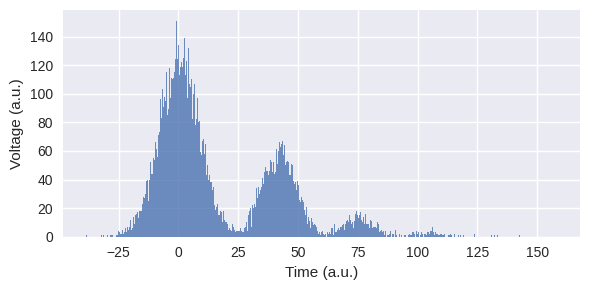

Initial objective function :  [5040.47495474 5040.47495474 5040.47495474 5040.47495474 5040.47495474
 5040.47495474 5040.47495474 5040.47495474 5040.47495474 5040.47495474
 5040.47495474]


ValueError: not enough values to unpack (expected 3, got 2)

In [15]:
pk = PIKA(
        nCool = 10,
        nGreedy = 10,
        nSigma = 4.,
        verbose = True
        )

pk.fit(
        data =data_train[np.newaxis, :10_000, :], 
        nPhotonAvgList = [3],
      )